In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
import gdown

In [3]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=42796e8f-4e6e-43dc-ba69-d64afb455777
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:04<00:00, 105MB/s]  


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [4]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"The size = {char_to_num.vocabulary_size()} "
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']The size = 40 


In [7]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [8]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [9]:
test_path = './data/s1/bbal6n.mpg'

In [10]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [11]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

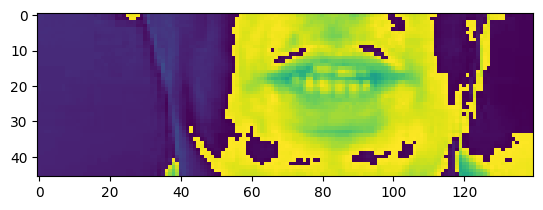

In [12]:
plt.imshow(frames[40])

In [13]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [14]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [15]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [16]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [17]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [18]:
len(test)

50

In [19]:
frames, alignments = data.as_numpy_iterator().next()

In [20]:
test = data.as_numpy_iterator()

In [21]:
val = test.next(); val[0]

array([[[[[ 1.4547566 ],
          [ 1.4547566 ],
          [ 1.4547566 ],
          ...,
          [10.598941  ],
          [10.557377  ],
          [10.557377  ]],

         [[ 1.4547566 ],
          [ 1.4547566 ],
          [ 1.4547566 ],
          ...,
          [10.598941  ],
          [10.557377  ],
          [10.557377  ]],

         [[ 1.3716277 ],
          [ 1.3716277 ],
          [ 1.3716277 ],
          ...,
          [ 0.        ],
          [10.598941  ],
          [10.598941  ]],

         ...,

         [[ 0.9559829 ],
          [ 0.9559829 ],
          [ 0.9559829 ],
          ...,
          [10.266425  ],
          [10.266425  ],
          [10.266425  ]],

         [[ 0.9559829 ],
          [ 0.9559829 ],
          [ 0.9559829 ],
          ...,
          [10.22486   ],
          [10.22486   ],
          [10.22486   ]],

         [[ 0.9559829 ],
          [ 0.9559829 ],
          [ 0.9559829 ],
          ...,
          [10.22486   ],
          [10.22486   ],
          

In [24]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [25]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [26]:
# Define input shape and number of classes
input_shape = (75, 46, 140, 1)  # (timesteps, height, width, channels)
num_classes = 41  # Number of output classes (e.g., phonemes or words)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Activation, Flatten, Reshape, Bidirectional, LSTM, Dropout, Dense

def create_lipreading_model(input_shape, num_classes):
    model = Sequential()

    # 3D Convolutional Layers
    model.add(Conv3D(128, kernel_size=(3, 3, 3), input_shape=(75, 46, 140, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(256, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(75, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    # Replace TimeDistributed with Reshape and Flatten
    # Output shape after MaxPooling3D: (batch_size, 75, 5, 17, 75)
    # Reshape to (batch_size, 75, 5 * 17 * 75) to flatten spatial dimensions
    model.add(Reshape((75, 5 * 17 * 75)))

    # Bidirectional RNN Layers
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [28]:
# Create the model
model = create_lipreading_model(input_shape, num_classes)

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
ypred = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [30]:
ypred[0].shape

(75, 41)

In [31]:
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch < 30:
        return float(lr)  # Ensure it returns a float
    else:
        return float(lr * tf.math.exp(-0.1).numpy())  # Convert tensor to float

In [32]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [33]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset  # ✅ No need for `.as_numpy_iterator()`
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [34]:
!pip install jiwer

In [35]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [36]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [37]:
checkpoint_callback = ModelCheckpoint(
    os.path.join('models', 'checkpoint.weights.h5'),  # ✅ Add `.weights.h5`
    monitor='loss',
    save_weights_only=True
)

In [38]:
schedule_callback = LearningRateScheduler(scheduler)

In [39]:
example_callback = ProduceExample(test)

In [43]:
x_test, y_test = next(iter(test))

In [44]:
history = model.fit(data, validation_data=(x_test, y_test) , epochs = 50, callbacks=[checkpoint_callback,schedule_callback,example_callback])

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/stepstep - loss: 65.78
Original: lay blue with k nine soon
Prediction: la e e t e ea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue sp with e six please
Prediction: la e e t e ea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 ━━━━━━━━━━━━━━━━━━━━ 498s 995ms/step - loss: 65.7815 - val_loss: 68.9050 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/stepstep - loss: 62.93
Original: set red by u seven soon
Prediction: la re i e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with n three again
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
500/500 ━━━━━━━━━━━━━━━━━━━━ 489s 978ms/step - loss: 62.9317 - val_loss: 67.3775 - learning_rate: 1.

In [45]:
model.save_weights("lipnet_trained.weights.h5")  # Corrected filename

In [46]:
model.save("lipnet_full_model.h5")  # Newer format
model.save("lipnet_full_model.keras") 

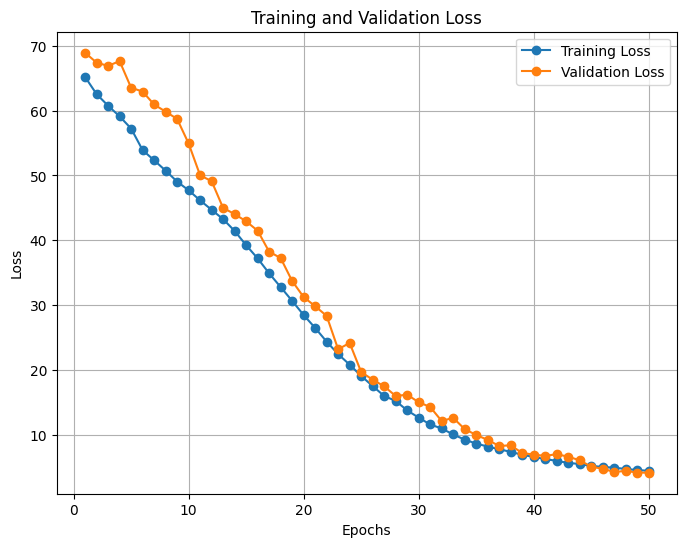

In [47]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history.get('val_loss', [])  # Handles case where val_loss may not be recorded
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
if val_loss:  # Plot validation loss if available
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [51]:
y_pred = model.predict(x_test)

# Get batch size and create correct input_length
batch_size = y_pred.shape[0]
input_length = np.full((batch_size,), y_pred.shape[1])

# Decode predictions
decoded_pred = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)[0][0].numpy()

# Print result
print(decoded_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[12  1 25 39  7 18  5  5 14 39 23  9 20  8 39 19  5 22  5 14 39 19 15 15
  14  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1]
 [ 2  9 14 39 23  8  9 20  5 39  2 25 39 20 39  5  9  7  8 39 19 16 12  5
   1 19  5  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1]]


In [52]:
# Define the vocabulary list
VOCAB = "abcdefghijklmnopqrstuvwxyz'?!0123456789 "

# Function to convert indices to text
def indices_to_text(indices, vocab):
    return ''.join([vocab[i] for i in indices if i >= 0])  # Ignore negative values

# Convert decoded predictions to text
decoded_texts = [indices_to_text(seq, VOCAB) for seq in decoded_pred]

# Print output
for i, text in enumerate(decoded_texts):
    print(f"Decoded Text {i+1}: {text}")


Decoded Text 1: mbz hsffo xjui tfwfo tppoaaaaaaaaaaaaa
Decoded Text 2: cjo xijuf cz u fjhi tqmfbtfaaaaaaaaaaa


In [56]:
test_data = test.next()  # Fetch one batch of test data


In [59]:
ypred = model.predict(test_data[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [60]:
decoded = tf.keras.backend.ctc_decode(ypred, input_length=[75,75], greedy = True)

In [64]:
# Assuming y_pred contains the model's predictions
decoded_pred = tf.keras.backend.ctc_decode(y_pred, input_length=[y_pred.shape[1]] * y_pred.shape[0], greedy=True)[0][0]

# Convert numerical predictions into text
sentences = [num_to_char(word.numpy()) for word in decoded_pred]

# Print predictions
predicted_sentences = [tf.strings.reduce_join(sentence).numpy().decode('utf-8') for sentence in sentences]
print(predicted_sentences)


['lay green with seven soon', 'bin white by t eigh splease']


In [71]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbaf3s.mpg'))

In [72]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
